In [104]:
import os
import sys
src_path = sys.path[0].replace("figures", "src")
# data_path = sys.path[0].replace("notebooks", "data")
if src_path not in sys.path:
    sys.path.append(src_path)

out_path = sys.path[0].replace("figures", "output")

import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

from profile_extraction import ProfileExtraction
from data_loader import UCSD_dataloader
from utils.plot_utils import *
customize_plt() # customize plt configs, see plot_utils

exp_suffix = "Mar2023"
exp_folder = os.path.join(out_path, "experiments", exp_suffix)
assert os.path.exists(exp_folder)

In [2]:
def df_filter(df, **kw):
    sig = None
    for k in kw.keys():
        if sig is None:
            sig = df[k] == kw[k]
        else:
            sig = sig & (df[k] == kw[k])
    return df.loc[sig]


def read_df(fn, **kw):
    df = pd.read_excel(fn, index_col=0)
    return df_filter(df, **kw).copy()
    
    
def get_identifier(df, cols):
    def lambda_id(x):
        s = ""
        for c in cols:
            s += f"_{c}-{x[c]}"
        return s[1:]
    return df.apply(lambda_id, axis=1)

In [105]:
log_rep_fn = os.path.join(exp_folder, "LOG-Size_TCO_rep.xlsx")
log_rep = read_df(log_rep_fn, status="D")

log_365_fn = os.path.join(exp_folder, "LOG-Size_TCO_365.xlsx")
log_365 = read_df(log_365_fn , status="D", days=365)

In [4]:
def TCO_curve(df, strategy, deg_model_opt, y="eq_rate"):
    df_sub = df_filter(df, strategy=strategy, deg_model_opt=deg_model_opt)
    opt_var = "B" if "B" in df.columns else "B_hr"
    df_sub = df_sub.loc[df_sub[opt_var] != "opt"]
    df_sub.sort_values(by="eq_bat_capacity", inplace=True)
    df_sub.index = df_sub["eq_bat_capacity"]
    return df_sub.loc[:,["eq_bat_capacity", "eq_rate", "eq_rate_est", "TCO", "TCO_est", "eq_cycles", "eq_cycles_est"]]

In [79]:
alg_list = ["RF", "UC", "MSC"]

alg_filter = {
    "RF": {"strategy" : "optimal", "deg_model_opt" : "rainflow"},
    "UC": {"strategy" : "optimal", "deg_model_opt" : "unconscious"},
    "MSC": {"strategy" : "MSC", "deg_model_opt" : "rainflow"},
}

alg_colors = {
    "RF": "green", "UC": "darkblue", "MSC": "indianred"
}

alg_names = {
    "RF": "RF",
    "UC": "UC",
    "MSC": "MSC"
}

alg_optimal = {
    "RF": 6.28,
    "UC": 5.30,
    "MSC": 4.2  # this is not an exact number
}

In [100]:
def draw_size_curve(alg, key, ax=None): 
    color = alg_colors[alg]
    
    idx0 = 1 if key == "eq_cycles" else 0

    est = TCO_curve(log_rep, **alg_filter[alg])
    ax.plot(est[f"{key}_est"][idx0:], c=color, ls="dotted")

    act = TCO_curve(log_365, **alg_filter[alg])
    ax.plot(act[key][idx0:], ls="solid", c=color)

    ax.vlines(alg_optimal[alg], -10, 10, color=color, lw=6, alpha=0.15, zorder=-200)

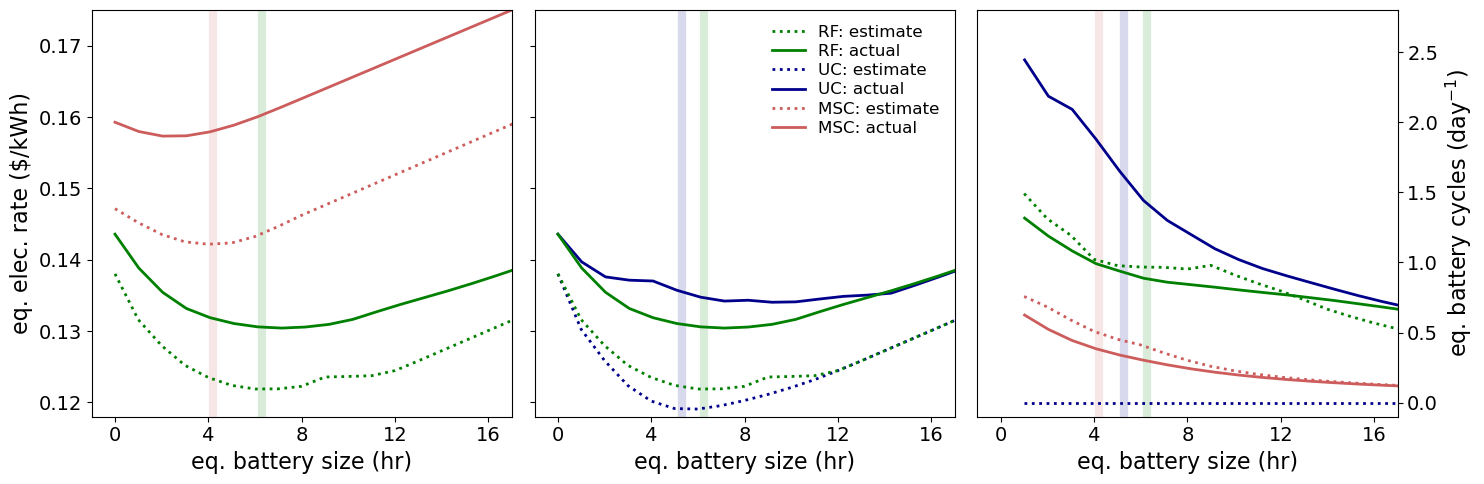

In [107]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))

for i in range(2):
    ax = axs[i]
    ax.set_ylim(0.118, 0.175)
    ax.set_xlim(-1,17)

    alg = "MSC" if i == 0 else "UC"
    draw_size_curve(alg, "eq_rate", ax=ax)

    draw_size_curve("RF", "eq_rate", ax=ax)

    if i == 0:
        ax.set_ylabel("eq. elec. rate ($/kWh)")

    if i == 1:
        ax.set_yticklabels([])
        
        for alg in alg_list:
            name = alg_names[alg]
            c = alg_colors[alg]
            ax.plot([0,0],[-100,-100], c=c, ls="dotted", label=f"{name}: estimate")
            ax.plot([0,0],[-100,-100], c=c, ls="solid", label=f"{name}: actual")
        ax.legend(handlelength=2, loc="upper right")

ax = axs[2]
ax.set_ylim(-0.1,2.8)
ax.set_xlim(-1,17)

for alg in alg_list:
    draw_size_curve(alg, "eq_cycles", ax)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
per = r'$^{-1}$'
ax.set_ylabel(f"eq. battery cycles (day{per})")



for i in range(3):
    ax = axs[i]
    ax.set_xticks(np.arange(0, 17, 4))
    ax.set_xlabel("eq. battery size (hr)")

plt.tight_layout()
plt.savefig("214-fig4-size_curves.png", dpi=300, facecolor="w", bbox_inches="tight")